In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paremetric-data/ml_enron.txt
/kaggle/input/paremetric-data/CollegeMsg.txt


In [2]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 41.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.2 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, b

In [3]:
import random
import networkx as nx
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Bidirectional, Dropout, Activation,SimpleRNN ,LSTM , TimeDistributed,Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from keras.optimizers import Adam,SGD
from keras.optimizers import AdamW
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers, activations
from node2vec import Node2Vec
from sklearn.metrics import average_precision_score
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
class TemporalRandomWalkSampler2:
    def __init__(self, filename=None, num_walks=3, alpha=0.5):
        self.num_walks = num_walks
        self.alpha = alpha
        if filename:
            self.temporal_network = self.load_temporal_network(filename)
        else:
            self.temporal_network = nx.Graph()

    def load_temporal_network(self, filename):
        temporal_network = nx.Graph()
        with open(filename, 'r') as file:
            next(file)  # Skip header if there is one
            for line in file:
                parts = line.strip().split(' ')
                if len(parts) == 3:
                    source, target, timestamp = parts
                    temporal_network.add_edge(source, target, time=int(timestamp))
                else:
                    print(f"Skipping invalid line: {line.strip()}")
        return temporal_network

    def sample_temporal_random_walks(self):
        node_sets = {}
        for node in self.temporal_network.nodes():
            walks = self._sample_trws(node)
            node_sets[node] = walks
        return node_sets

    def _sample_trws(self, start_node):
        walks = []
        for _ in range(self.num_walks):
            walk = self.temporal_walk(self.temporal_network, start_node)
            walks.append(walk)
        return walks

    def temporal_walk(self, G, start_node, L=7):
        current_node = start_node
        walk = [current_node]
        current_time = 0

        for _ in range(1, L + 1):
            neighbors = [(neighbor, G.edges[current_node, neighbor]['time']) for neighbor in G.neighbors(current_node)]
            valid_edges = [(neighbor, time) for neighbor, time in neighbors if time > current_time]

            if valid_edges:
                next_node, interaction_time = self.biased_edge_selection(valid_edges, current_time)
                walk.append(interaction_time)
                walk.append(next_node)
                current_node = next_node
                current_time = interaction_time
            else:
                break

        return walk

    def biased_edge_selection(self, valid_edges, current_time):
        weights = [np.exp(-self.alpha * (edge[1] - current_time)) for edge in valid_edges]
        sum_weights = np.sum(weights)

        if sum_weights == 0 or np.isnan(sum_weights):
            # Handle the case when all weights are zero or NaN
            return random.choice(valid_edges)
        else:
            normalized_weights = weights / sum_weights
            selected_index = np.random.choice(len(valid_edges), p=normalized_weights)
            return valid_edges[selected_index]


In [4]:
def extract_temporal_motifs(walks, motif_sizes):
    motifs = {}
    for size in motif_sizes:
        size_motifs = set()
        for walk in walks:
            for i in range(0, len(walk) - size * 2 + 1, 2):
                motif = tuple(walk[i:i + size * 2:2])
                size_motifs.add(motif)
        motifs[size] = size_motifs
    return motifs

def anonymize_motifs(motifs):
    node_encoder = OneHotEncoder()
    flattened_motifs = [str(node) for size in motifs for motif in motifs[size] for node in motif]
    node_encoder.fit(np.array(flattened_motifs).reshape(-1, 1))

    anonymized_motifs = {}
    for size, size_motifs in motifs.items():
        anonymized_size_motifs = set()
        for motif in size_motifs:
            encoded_motif = tuple(tuple(node_encoder.transform(np.array([[str(node)]]).reshape(-1, 1)).toarray().flatten()) for node in motif)
            anonymized_size_motifs.add(encoded_motif)
        anonymized_motifs[size] = anonymized_size_motifs

    return anonymized_motifs

def create_incidence_matrices(motifs):
    incidence_matrices = {}

    for size, size_motifs in motifs.items():
        vertices = set()
        hyperedges = []

        for motif in size_motifs:
            vertices.update(motif)
            hyperedges.append(motif)

        vertices = sorted(vertices)
        num_vertices = len(vertices)
        num_hyperedges = len(hyperedges)

        incidence_matrix = np.zeros((num_vertices, num_hyperedges))

        for j, hyperedge in enumerate(hyperedges):
            for vertex in hyperedge:
                i = vertices.index(vertex)
                incidence_matrix[i, j] = 1

        incidence_matrices[size] = (incidence_matrix, vertices, hyperedges)

    return incidence_matrices

def extract_node_features(temporal_network, incidence_matrices):
    node_features = {}

    for size, (incidence_matrix, vertices, hyperedges) in incidence_matrices.items():
        # Extract features from the incidence matrix for each node
        node_degree = incidence_matrix.sum(axis=1)  # Degree centrality
        node_closeness = np.reciprocal(incidence_matrix.sum(axis=1))  # Closeness centrality
        node_betweenness = np.sum(incidence_matrix, axis=1)  # Betweenness centrality

        # Combine the features into a feature matrix
        features = np.column_stack((node_degree, node_closeness, node_betweenness))

        # Store the features in a dictionary with node labels as keys
        node_features[size] = {node: feature for node, feature in zip(vertices, features)}

    # Extract Node2Vec embeddings
    node2vec = Node2Vec(temporal_network, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    node2vec_features = {str(node): model.wv[str(node)] for node in temporal_network.nodes()}

    # Merge all features
    merged_features = {}
    for node in temporal_network.nodes():
        embedding_features = node2vec_features[str(node)]
        if node in node_features:
            basic_features = np.concatenate([features[node] for size, features in node_features.items() if node in features])
            merged_features[node] = np.concatenate((basic_features, embedding_features))
        else:
            merged_features[node] = embedding_features

    return merged_features

In [5]:
def prepare_link_prediction_data(temporal_network, node_features, train_size=0.7, val_size=0.15):
    positive_samples = []
    negative_samples = []

    nodes = list(temporal_network.nodes())

    # Create positive samples
    for edge in temporal_network.edges():
        source, target = edge
        if source in node_features and target in node_features:
            positive_samples.append((source, target, node_features[source], node_features[target], 1))

    # Create negative samples
    while len(negative_samples) < len(positive_samples):
        source, target = random.sample(nodes, 2)
        if not temporal_network.has_edge(source, target):
            if source in node_features and target in node_features:
                negative_samples.append((source, target, node_features[source], node_features[target], 0))

    samples = positive_samples + negative_samples
    random.shuffle(samples)

    # Check for inconsistent feature lengths
    max_len = max(len(s[2]) for s in samples)
    print(f"Maximum feature length: {max_len}")
    for s in samples:
        print(f"Feature lengths: {len(s[2])}, {len(s[3])}")

    # Pad or trim features to ensure uniform length
    X = np.array([np.concatenate((pad_or_trim(s[2], max_len), pad_or_trim(s[3], max_len))) for s in samples])
    y = np.array([s[4] for s in samples])
    edge_info = [(s[0], s[1]) for s in samples]

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data into training, validation, and testing sets using StratifiedShuffleSplit
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=(1 - train_size), random_state=42)

    for train_index, temp_index in stratified_split.split(X, y):
        X_train, X_temp = X[train_index], X[temp_index]
        y_train, y_temp = y[train_index], y[temp_index]
        edge_info_train, edge_info_temp = [edge_info[i] for i in train_index], [edge_info[i] for i in temp_index]

    print("Train, Validation, and Test splits created.")

    # Further split the temp data into validation and test sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=(val_size / (1 - train_size)), random_state=42)

    for val_index, test_index in stratified_split.split(X_temp, y_temp):
        X_val, X_test = X_temp[val_index], X_temp[test_index]
        y_val, y_test = y_temp[val_index], y_temp[test_index]
        edge_info_val, edge_info_test = [edge_info_temp[i] for i in val_index], [edge_info_temp[i] for i in test_index]

    print("Data preparation complete.")
    return X_train, X_val, X_test, y_train, y_val, y_test, edge_info_train, edge_info_val, edge_info_test


In [6]:
def pad_or_trim(array, length):
    if len(array) < length:
        return np.pad(array, (0, length - len(array)), 'constant')
    else:
        return array[:length]

In [7]:
def create_lstm_link_prediction_model(input_shape, activation_function, optimizer):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, activation=activation_function, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),  # Adding dropout to prevent overfitting
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification (link or no link)
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# **Alpha**

In [11]:
def run_experiment(filename, alpha_list):
    results = {'alpha': [], 'average_precision': []}

    num_walks = 30  # Keeping num_walks constant
    L = 7          # Keeping L constant

    for alpha in alpha_list:
        # Initialize the sampler with the current alpha
        temporal_rw_sampler = TemporalRandomWalkSampler(filename, num_walks=num_walks, alpha=alpha)
        
        # Sample temporal random walks for each node in the graph
        node_sets = temporal_rw_sampler.sample_temporal_random_walks()
        
        # Extract temporal motifs from the sampled walks
        all_walks = [walk for walks in node_sets.values() for walk in walks]
        motif_sizes = [3, 4, 5, 6]
        extracted_motifs = extract_temporal_motifs(all_walks, motif_sizes)
        
        # Create incidence matrices for each n-node motif type
        incidence_matrices = create_incidence_matrices(extracted_motifs)
        
        # Extract node features from the incidence matrices
        node_features = extract_node_features(temporal_rw_sampler.temporal_network, incidence_matrices)
        
        # Prepare data for link prediction
        X_train, X_val, X_test, y_train, y_val, y_test, edge_info_train, edge_info_val, edge_info_test = prepare_link_prediction_data(
            temporal_rw_sampler.temporal_network, node_features
        )
        
        # Reshape the input data to 3D (samples, timesteps, input_dim)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        
        # Create the LSTM model
        activation_function = 'tanh'
        optimizer = SGD(learning_rate=0.01)
        model = create_lstm_link_prediction_model((X_train.shape[1], X_train.shape[2]), activation_function, optimizer)
        
        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        # Train the model
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
        
        # Predicting on the test set
        y_pred_prob = model.predict(X_test)
        
        # Calculate average precision score
        average_precision = average_precision_score(y_test, y_pred_prob)
        
        # Store results
        results['alpha'].append(alpha)
        results['average_precision'].append(average_precision)

    return pd.DataFrame(results)

In [12]:
# Run experiments for both datasets
dataset1_results = run_experiment('/kaggle/input/paremetric-data/ml_enron.txt', alpha_list=[0.3, 0.4, 0.5])

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:06<00:00,  8.07it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:06<00:00,  7.78it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:06<00:00,  7.62it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

In [13]:
dataset1_results

alpha  average_precision
0    0.3           0.949949
1    0.4           0.948101
2    0.5           0.937781

In [14]:
dataset2_results = run_experiment('/kaggle/input/paremetric-data/CollegeMsg.txt', alpha_list=[0.3, 0.4, 0.5])

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [01:36<00:00,  1.94s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

In [16]:
dataset2_results

alpha  average_precision
0    0.3           0.988593
1    0.4           0.985699
2    0.5           0.983486

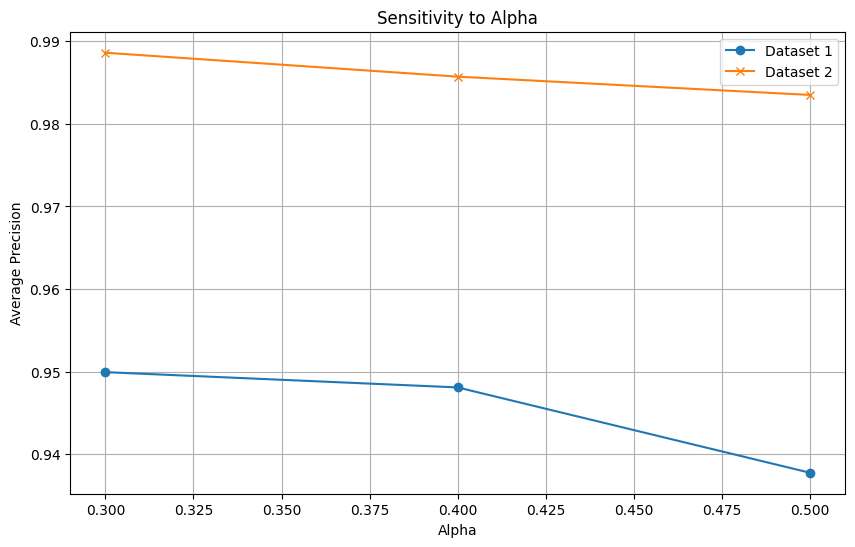

In [15]:
# Plotting results for alpha
plt.figure(figsize=(10, 6))
plt.plot(dataset1_results['alpha'], dataset1_results['average_precision'], marker='o', label='Dataset 1')
plt.plot(dataset2_results['alpha'], dataset2_results['average_precision'], marker='x', label='Dataset 2')
plt.xlabel('Alpha')
plt.ylabel('Average Precision')
plt.title('Sensitivity to Alpha')
plt.legend()
plt.grid(True)
plt.show()

# **Num Walks**

In [17]:
def run_experiment(filename, num_walks_list):
    results = {'num_walks': [], 'average_precision': []}

    alpha = 0.5  # Keeping alpha constant
    L = 7       # Keeping L constant

    for num_walks in num_walks_list:
        # Initialize the sampler with the current num_walks
        temporal_rw_sampler = TemporalRandomWalkSampler2(filename, num_walks=num_walks, alpha=alpha)
        
        # Sample temporal random walks for each node in the graph
        node_sets = temporal_rw_sampler.sample_temporal_random_walks()
        
        # Extract temporal motifs from the sampled walks
        all_walks = [walk for walks in node_sets.values() for walk in walks]
        motif_sizes = [3, 4, 5, 6]
        extracted_motifs = extract_temporal_motifs(all_walks, motif_sizes)
        
        # Create incidence matrices for each n-node motif type
        incidence_matrices = create_incidence_matrices(extracted_motifs)
        
        # Extract node features from the incidence matrices
        node_features = extract_node_features(temporal_rw_sampler.temporal_network, incidence_matrices)
        
        # Prepare data for link prediction
        X_train, X_val, X_test, y_train, y_val, y_test, edge_info_train, edge_info_val, edge_info_test = prepare_link_prediction_data(
            temporal_rw_sampler.temporal_network, node_features
        )
        
        # Reshape the input data to 3D (samples, timesteps, input_dim)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        
        # Create the LSTM model
        activation_function = 'tanh'
        optimizer = SGD(learning_rate=0.01)
        model = create_lstm_link_prediction_model((X_train.shape[1], X_train.shape[2]), activation_function, optimizer)
        
        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        # Train the model
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
        
        # Predicting on the test set
        y_pred_prob = model.predict(X_test)
        
        # Calculate average precision score
        average_precision = average_precision_score(y_test, y_pred_prob)
        
        # Store results
        results['num_walks'].append(num_walks)
        results['average_precision'].append(average_precision)

    return pd.DataFrame(results)

In [18]:
dataset1_results = run_experiment('/kaggle/input/paremetric-data/ml_enron.txt', num_walks_list=[10, 20, 30, 40])

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:04<00:00, 12.11it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:03<00:00, 12.75it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:03<00:00, 12.65it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

In [21]:
dataset1_results

num_walks  average_precision
0         10           0.949843
1         20           0.949672
2         30           0.928476
3         40           0.965914

In [20]:
dataset2_results = run_experiment('/kaggle/input/paremetric-data/CollegeMsg.txt', num_walks_list=[10, 20, 30 ,40])

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

In [22]:
dataset2_results

num_walks  average_precision
0         10           0.984763
1         20           0.988039
2         30           0.990172
3         40           0.987687

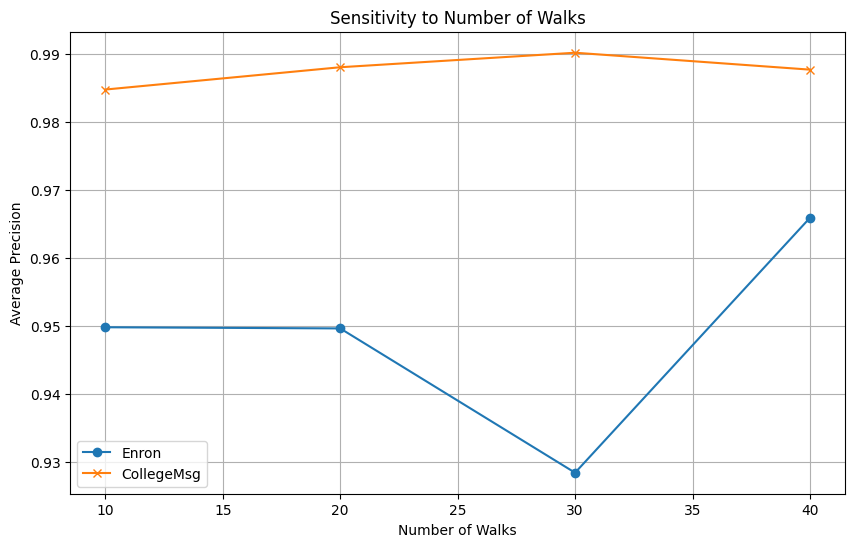

In [23]:
# Plotting results for num_walks
plt.figure(figsize=(10, 6))
plt.plot(dataset1_results['num_walks'], dataset1_results['average_precision'], marker='o', label='Enron')
plt.plot(dataset2_results['num_walks'], dataset2_results['average_precision'], marker='x', label='CollegeMsg')
plt.xlabel('Number of Walks')
plt.ylabel('Average Precision')
plt.title('Sensitivity to Number of Walks')
plt.legend()
plt.grid(True)
plt.show()

# **Walk length**

In [25]:
class TemporalRandomWalkSampler:
    def __init__(self, filename=None, num_walks=3, alpha=0.5):
        self.num_walks = num_walks
        self.alpha = alpha
        if filename:
            self.temporal_network = self.load_temporal_network(filename)
        else:
            self.temporal_network = nx.Graph()

    def load_temporal_network(self, filename):
        temporal_network = nx.Graph()
        with open(filename, 'r') as file:
            next(file)  # Skip header if there is one
            for line in file:
                parts = line.strip().split(' ')
                if len(parts) == 3:
                    source, target, timestamp = parts
                    temporal_network.add_edge(source, target, time=int(timestamp))
                else:
                    print(f"Skipping invalid line: {line.strip()}")
        return temporal_network

    def sample_temporal_random_walks(self, L):
        node_sets = {}
        for node in self.temporal_network.nodes():
            walks = self._sample_trws(node, L)
            node_sets[node] = walks
        return node_sets

    def _sample_trws(self, start_node, L):
        walks = []
        for _ in range(self.num_walks):
            walk = self.temporal_walk(self.temporal_network, start_node, L)
            walks.append(walk)
        return walks

    def temporal_walk(self, G, start_node, L=7):
        current_node = start_node
        walk = [current_node]
        current_time = 0

        for _ in range(1, L + 1):
            neighbors = [(neighbor, G.edges[current_node, neighbor]['time']) for neighbor in G.neighbors(current_node)]
            valid_edges = [(neighbor, time) for neighbor, time in neighbors if time > current_time]

            if valid_edges:
                next_node, interaction_time = self.biased_edge_selection(valid_edges, current_time)
                walk.append(interaction_time)
                walk.append(next_node)
                current_node = next_node
                current_time = interaction_time
            else:
                break

        return walk

    def biased_edge_selection(self, valid_edges, current_time):
        weights = [np.exp(-self.alpha * (edge[1] - current_time)) for edge in valid_edges]
        sum_weights = np.sum(weights)

        if sum_weights == 0 or np.isnan(sum_weights):
            # Handle the case when all weights are zero or NaN
            return random.choice(valid_edges)
        else:
            normalized_weights = weights / sum_weights
            selected_index = np.random.choice(len(valid_edges), p=normalized_weights)
            return valid_edges[selected_index]

In [27]:
def run_experiment_with_L(filename, L_list):
    results = {'L': [], 'average_precision': []}

    num_walks = 30  # Keeping num_walks constant
    alpha = 0.4     # Keeping alpha constant

    for L in L_list:
        # Initialize the sampler with the current L
        temporal_rw_sampler = TemporalRandomWalkSampler(filename, num_walks=num_walks, alpha=alpha)
        
        # Sample temporal random walks with the current L
        node_sets = temporal_rw_sampler.sample_temporal_random_walks(L=L)
        
        # Extract temporal motifs from the sampled walks
        all_walks = [walk for walks in node_sets.values() for walk in walks]
        motif_sizes = [3, 4, 5, 6]
        extracted_motifs = extract_temporal_motifs(all_walks, motif_sizes)
        
        # Create incidence matrices for each n-node motif type
        incidence_matrices = create_incidence_matrices(extracted_motifs)
        
        # Extract node features from the incidence matrices
        node_features = extract_node_features(temporal_rw_sampler.temporal_network, incidence_matrices)
        
        # Prepare data for link prediction
        X_train, X_val, X_test, y_train, y_val, y_test, edge_info_train, edge_info_val, edge_info_test = prepare_link_prediction_data(
            temporal_rw_sampler.temporal_network, node_features
        )
        
        # Reshape the input data to 3D (samples, timesteps, input_dim)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        
        # Create the LSTM model
        activation_function = 'tanh'
        optimizer = SGD(learning_rate=0.01)
        model = create_lstm_link_prediction_model((X_train.shape[1], X_train.shape[2]), activation_function, optimizer)
        
        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        # Train the model
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
        
        # Predicting on the test set
        y_pred_prob = model.predict(X_test)
        
        # Calculate average precision score
        average_precision = average_precision_score(y_test, y_pred_prob)
        
        # Store results
        results['L'].append(L)
        results['average_precision'].append(average_precision)

    return pd.DataFrame(results)

In [28]:
dataset1_results = run_experiment_with_L('/kaggle/input/paremetric-data/ml_enron.txt', L_list=[1, 2, 3, 4])

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:04<00:00, 10.97it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:04<00:00, 12.05it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:04<00:00, 12.26it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/184 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:04<00:00, 12.42it/s]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

In [29]:
dataset1_results

L  average_precision
0  1           0.935910
1  2           0.945352
2  3           0.942536
3  4           0.941354

In [30]:
dataset2_results = run_experiment_with_L('/kaggle/input/paremetric-data/CollegeMsg.txt', L_list=[1, 2, 3, 4])

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

Computing transition probabilities:   0%|          | 0/1899 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Maximum feature length: 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengths: 64, 64
Feature lengt

In [31]:
dataset2_results

L  average_precision
0  1           0.986237
1  2           0.986229
2  3           0.989075
3  4           0.985142

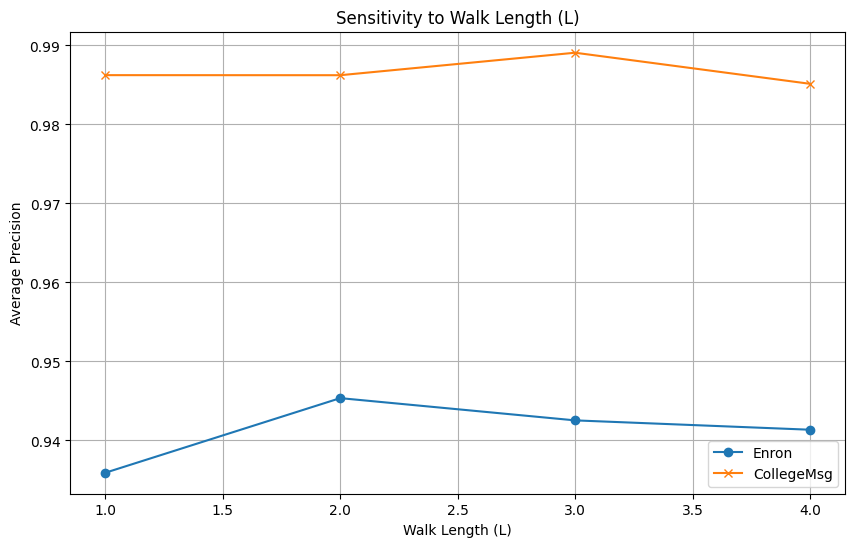

In [32]:
# Plotting results for walk length L
plt.figure(figsize=(10, 6))
plt.plot(dataset1_results['L'], dataset1_results['average_precision'], marker='o', label='Enron')
plt.plot(dataset2_results['L'], dataset2_results['average_precision'], marker='x', label='CollegeMsg')
plt.xlabel('Walk Length (L)')
plt.ylabel('Average Precision')
plt.title('Sensitivity to Walk Length (L)')
plt.legend()
plt.grid(True)
plt.show()